## Learning a function with a variable number of inputs with PyTorch

This notebook is licensed under the Creative Commons cc by-sa 3.0 License.

See the full article here: https://medium.com/@andre.holzner/learning-a-function-with-a-variable-number-of-inputs-with-pytorch-c487e35d4dba

In [1]:
import numpy as np
np.random.seed(1773)

import matplotlib.pyplot as plt
import math
%matplotlib inline

plt.rcParams['figure.figsize'] = (8.0, 8.0)

from math import sqrt

In [2]:
# range of variances to generate
varianceRange = [ 0.5, 1.5 ]

# total number of points to generate
numRows = 10000

# minimum and maximum number of points to draw from each distribution 
# (both inclusive)
numPointsRange = [ 10, 20 ]


In [3]:
# generate true variances of Gaussians
# convert to float32 to avoid incompatible data types during training
trueVariances = np.random.uniform(
                   varianceRange[0], varianceRange[1], numRows).astype('float32')

trueSigmas = np.sqrt(trueVariances)

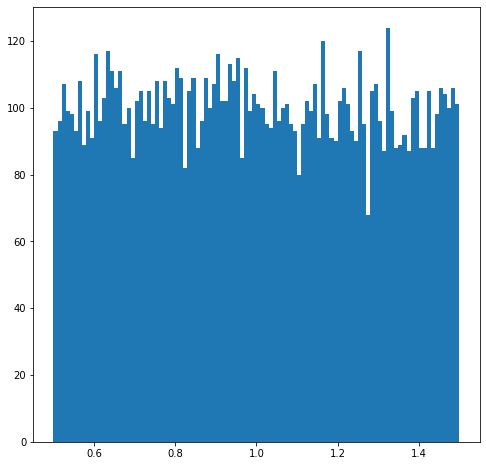

In [4]:
plt.hist(trueVariances, bins = 100);

### draw points from the distributions

In [5]:
# determine how many points should be drawn from each Gaussian
numPoints = np.random.randint(numPointsRange[0], numPointsRange[1] + 1, size = numRows)

# draw a set of points from the Gaussian
xvalues = []

for row in range(numRows):
    thisNumPoints = numPoints[row]

    # draw points from this Gaussian
    xv = np.random.normal(loc = 0, scale = trueSigmas[row], size = (thisNumPoints,1))
    
    # convert to float32 to avoid problems with incompatible data types during training
    xvalues.append(xv.astype('float32'))
    
# calculate ML estimators for each point
mlEstimators = np.array([ np.var(xv, ddof = 0) for xv in xvalues], dtype = 'float32')

# calculate unbiased estimators for each point
ubEstimators = np.array([ np.var(xv, ddof = 1) for xv in xvalues], dtype = 'float32')

### plot a single example Gaussian

In [6]:
def plotExample(row, variances, xvalues, variancePredictions = None):
    # draw a single case
    
    xrange = np.linspace(-4,+4,101)
    
    from scipy.stats import norm
    
    #----------
    # plot the Gaussian
    #----------

    pdf = norm(loc = 0, scale = sqrt(variances[row])).pdf
    
    yvalues = pdf(xrange)
    plt.plot(xrange, yvalues)

    #----------

    ymin = min(yvalues); ymax = max(yvalues)
    
    ytrue  = 0.6 * ymax + 0.4 * ymin
    yestU  = 0.5 * ymax + 0.5 * ymin
    yestML = 0.4 * ymax + 0.6 * ymin
    ypred  = 0.3 * ymax + 0.7 * ymin
    
    #----------
    # plot points on Gaussian
    #----------

    yvalues = pdf(xvalues[row])
    plt.plot(xvalues[row], yvalues, 'o')
    
    #----------
    # plot true sigma
    #----------
    sigma = sqrt(variances[row])
    plt.plot([ - sigma, + sigma ], [ytrue, ytrue], label = 'true (%.2f)' % sigma)
    
    #----------
    # plot ML and unbiased estimator of the variance
    #----------
    
    for label, ddof, ypos in (
       ('unbiased est.', 1, yestU),
       ('ML est.', 0, yestML),
    ):
    
        sigma = sqrt(np.var(xvalues[row], ddof = ddof))
        plt.plot([ - sigma, + sigma ], [ypos, ypos], label = label + ' (%.2f)' % sigma)
    

    #----------
    # plot prediction
    #----------
    if variancePredictions is not None:
        sigma = sqrt(variancePredictions[row])
        
        plt.plot([ - sigma, + sigma ], [ypred, ypred], label = 'predicted (%.2f)' % sigma)

    
    
    plt.grid()

    plt.legend()


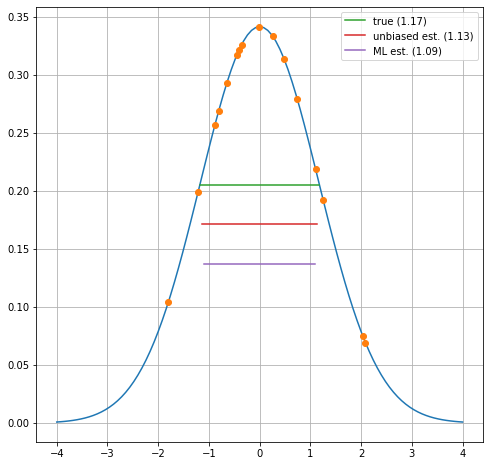

In [7]:
plotExample(0, trueVariances, xvalues)

In [8]:
# split into train and test set
from sklearn.model_selection import train_test_split

(inputTrain, inputTest, 
 targetTrain, targetTest,
 indicesTrain, indicesTest) = train_test_split(xvalues, 
                                               trueVariances, 
                                               # mlEstimators,
                                               # trueMeans,
                                               
                                               np.arange(numRows),
                                               test_size=0.20, random_state=42)


### build the network

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import operator

In [18]:
class Net(nn.Module):
    
    def __init__(self, 
                 numLayersInputSide  = 5, 
                 widthInputSide      = 50,
                 numLayersOutputSide = 5,
                 widthOutputSide     = 50,
                ):
        
        super(Net, self).__init__()
        
        #----------
        # input side layers
        #----------

        numInputs = 1
        
        self.inputSideLayers = []
        for i in range(numLayersInputSide):
            layer = nn.Linear(numInputs, widthInputSide)
            self.inputSideLayers.append(layer)
            self.add_module("iLayer%d" % i, layer)
            
            numInputs = widthInputSide

        #----------
        # output side layers
        #----------

        numInputs = widthInputSide
        numOutputs = widthOutputSide
        
        self.outputSideLayers = []
        for i in range(numLayersOutputSide):
          
            if i == numLayersOutputSide - 1:
                # we want to learn the variance
                numOutputs = 1
            else:
                numOutputs = widthOutputSide
            
            layer = nn.Linear(numInputs, numOutputs)
            self.outputSideLayers.append(layer)
            self.add_module("oLayer%d" % i, layer)
            
            numInputs = numOutputs
             
    #----------------------------------------
    
    def forward(self, points):
        
        # points is a list of list if 2D points
        # the first index is the minibatch index, the second index is the index
        # of the point within the row
                    
        # overall output for the entire minibatch
        outputs = []
        
        # loop over minibatch entries
        for thisPoints in points:

            # outputs of each point of this minibatch entry
            thisOutputs = [ ]
            
            # thisPoints is a list of 1D tensors
            # stack all input points into a 2D tensor
            # (the second dimension will have size 1)
            h = np.stack(thisPoints)
            
            h = Variable(torch.from_numpy(h))
            
            # forward all input points through the input side network
            for layer in self.inputSideLayers:
                h = layer(h)
                h = F.relu(h)
                            
            # average the input side network outputs: sum along first dimension (point index), 
            # then divide by number of points
            output = h.sum(0) / len(thisPoints)
            
            # feed through the output side network
            h = output
            for layerIndex, layer in enumerate(self.outputSideLayers):
                
                h = layer(h)

                # note: since we want to do regression, we do NOT 
                # apply a nonlinearity after the last layer
                
                if layerIndex != len(self.outputSideLayers) - 1:
                    h = F.relu(h)
                
            outputs.append(h)
            
        # end of loop over minibatch entries
         
        # convert the list of outputs to a torch 2D tensor
        return torch.cat(outputs, 0)            

In [21]:
model 

Net(
  (iLayer0): Linear(in_features=1, out_features=50, bias=True)
  (iLayer1): Linear(in_features=50, out_features=50, bias=True)
  (iLayer2): Linear(in_features=50, out_features=50, bias=True)
  (iLayer3): Linear(in_features=50, out_features=50, bias=True)
  (iLayer4): Linear(in_features=50, out_features=50, bias=True)
  (oLayer0): Linear(in_features=50, out_features=50, bias=True)
  (oLayer1): Linear(in_features=50, out_features=50, bias=True)
  (oLayer2): Linear(in_features=50, out_features=50, bias=True)
  (oLayer3): Linear(in_features=50, out_features=50, bias=True)
  (oLayer4): Linear(in_features=50, out_features=1, bias=True)
)

### run the training

In [20]:
# instantiate the model
model = Net()

allIndices = np.arange(len(targetTrain))

# define the loss function
lossFunc = nn.MSELoss()

minibatchSize = 32

# number of training epochs
numEpochs = 40

optimizer = optim.Adam(model.parameters(), lr = 0.0001)

trainLosses = []; testLosses = []

# variable for target values of test set
testTargetVar = Variable(torch.from_numpy(np.stack(targetTest)))

print("starting training")
for epoch in range(numEpochs):

    np.random.shuffle(allIndices)
    
    # put model in training mode
    model.train()
    
    trainLoss  = 0
    trainSteps = 0
    
    for indices in np.array_split(allIndices, minibatchSize):
        
        optimizer.zero_grad()
    
        # forward through the network
        output = model.forward([ inputTrain[index] for index in indices])
    
        # build a PyTorch variable with the target value
        # so that we can propagate backwards afterwards
        thisTarget = Variable(
            torch.from_numpy(np.stack([ targetTrain[index] for index in indices ])))
    
        # calculate loss
        loss = lossFunc.forward(output, thisTarget)
   
        # accumulate 
        trainLoss = trainLoss + loss.data[0]

        # backpropagate 
        loss.backward()
                            
        # update learning rate        
        optimizer.step()
        
        trainSteps = trainSteps+ 1
        
    trainLoss /= trainSteps
    trainLosses.append(trainLoss)    
        
    # evaluate model on test set
    model.eval()
        
    output = model.forward(inputTest)
            
    # calculate loss on test set
    testLoss = lossFunc.forward(output, testTargetVar).data[0]

    testLosses.append(testLoss)
    
    print("epoch",epoch,"train loss=", trainLoss, "test loss=",testLoss)

starting training


IndexError: invalid index of a 0-dim tensor. Use `tensor.item()` in Python or `tensor.item<T>()` in C++ to convert a 0-dim tensor to a number

### plot training progress

In [ ]:
plt.plot(range(1, len(trainLosses) + 1), trainLosses, label = 'train (last=%.3f)' % trainLosses[-1])
plt.plot(range(1, len(testLosses) + 1), testLosses, label = 'test (last=%.3f)' % testLosses[-1])
plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss');

### show a distribution of predictions minus true value for the test set

In [14]:
model.eval()

predictions = model.forward(inputTest).data.numpy()[:,0]

NameError: name 'model' is not defined

### compare different ways of estimating the variance

In [13]:
def absDiffFunc(prediction, trueValues):
    absDiff = prediction - trueValues
    return sqrt(np.mean(absDiff**2))

import pandas as pd

df = pd.DataFrame(dict(estimator = [
    "network prediction",
    "ML estimator",
    "unbiased estimator",
     ], 
                 
    rmse = [ 
      absDiffFunc(predictions, targetTest),
      absDiffFunc(np.sqrt([ np.var(x, ddof = 0) for x in inputTest]), targetTest),
      absDiffFunc(np.sqrt([ np.var(x, ddof = 1) for x in inputTest]), targetTest)
    ]))

df
                  

NameError: name 'predictions' is not defined